In [ ]:
# AMATH 581 HW 3
# Jonathan McCormack 

import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import cv2 as cv

## Part I: Randomized PCA implementation and validation

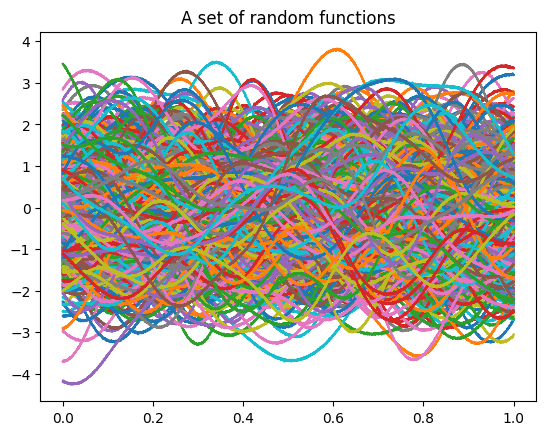

(4096, 1000)


In [2]:
## This block of code is provided by the instructor to generate a set of 1000x random functions 
## These functions have 4096 data points from x=0.0 to x=1.0

# covariance function 

def k(t, l):

  val = np.exp( - ( (t**2)/(2*l**2) ) )

  return val

N_grid = 2**12

grid = np.linspace(0, 1, N_grid)

# construct covariance matrix 
l = 0.1

dist = distance_matrix(np.transpose(np.asmatrix(grid)), np.transpose(np.asmatrix(grid)))

C = k(dist, l)
nugget = 1e-4*np.identity(C.shape[0])

CC = np.linalg.cholesky( C  + nugget)

N_samples = 1000 # number of random functions we want

data = []
for i in range(N_samples):
  
  sample = np.dot(CC,np.random.randn(N_grid,1)) 

  data.append(sample)

  plt.plot(grid, sample)

data = np.transpose(np.squeeze(np.asarray(data)))

plt.title('A set of random functions')
plt.savefig('Figure1.png') 
plt.show()

print(data.shape)

In [3]:
## Algorithms from Martinsson and Tropp, "Randomized numerical linear algebra: Foundations and algorithms", Acta Numerica, 2020
## These provided algorithms allow one to more quickly extract a low rank approximation of a large data matrix than the full SVD.

def randomized_range_finder(X, k, p):
    
    #Algorithm 1: Randomized Range Finder
    #Input: Data matrix X, target rank k, oversampling parameter p.
    #Output: Orthonormal matrix Q.
    
    m, n = X.shape
    # 1: Draw a Gaussian random matrix W
    W = np.random.randn(n, k + p)
    # 2: Form the sample matrix Y = XW
    Y = X @ W
    # 3: Compute the QR factorization Y = QR
    Q, _ = np.linalg.qr(Y)
    return Q

def randomized_svd_truncated(X, k, p):
    
    #Algorithm 2: Randomized SVD
    #Input: Data matrix X, target rank k, oversampling parameter p.
    #Output: Approximate rank-k SVD components Uk, Sk, Vk.

    Q = randomized_range_finder(X, k, p) # Use Algorithm 1
    # 1: Form the matrix B = Q.T @ X
    B = Q.T @ X 
    # 2: Compute the Economy SVD of the small matrix B
    U_hat, S_hat, Vt_hat = np.linalg.svd(B, full_matrices=False) 
    # 3: Form the approximate left singular vectors of X as U = Q @ U_hat
    U = Q @ U_hat 
    # 4: Truncate U, S_hat, Vt_hat to retain only the top k components
    Uk = U[:, :k]
    Sk = S_hat[:k]
    Vtk = Vt_hat[:k, :]
    return Uk, Sk, Vtk


k=5 and p=0: Mean Fro Error = 1104.613 and Std Dev Fro Error = 75.391
k=5 and p=5: Mean Fro Error = 808.024 and Std Dev Fro Error = 25.158
k=5 and p=10: Mean Fro Error = 757.318 and Std Dev Fro Error = 0.480
k=10 and p=0: Mean Fro Error = 365.527 and Std Dev Fro Error = 73.303
k=10 and p=5: Mean Fro Error = 160.466 and Std Dev Fro Error = 10.316
k=10 and p=10: Mean Fro Error = 144.245 and Std Dev Fro Error = 2.566
k=20 and p=0: Mean Fro Error = 48.967 and Std Dev Fro Error = 4.437
k=20 and p=5: Mean Fro Error = 34.661 and Std Dev Fro Error = 0.978
k=20 and p=10: Mean Fro Error = 30.057 and Std Dev Fro Error = 0.896


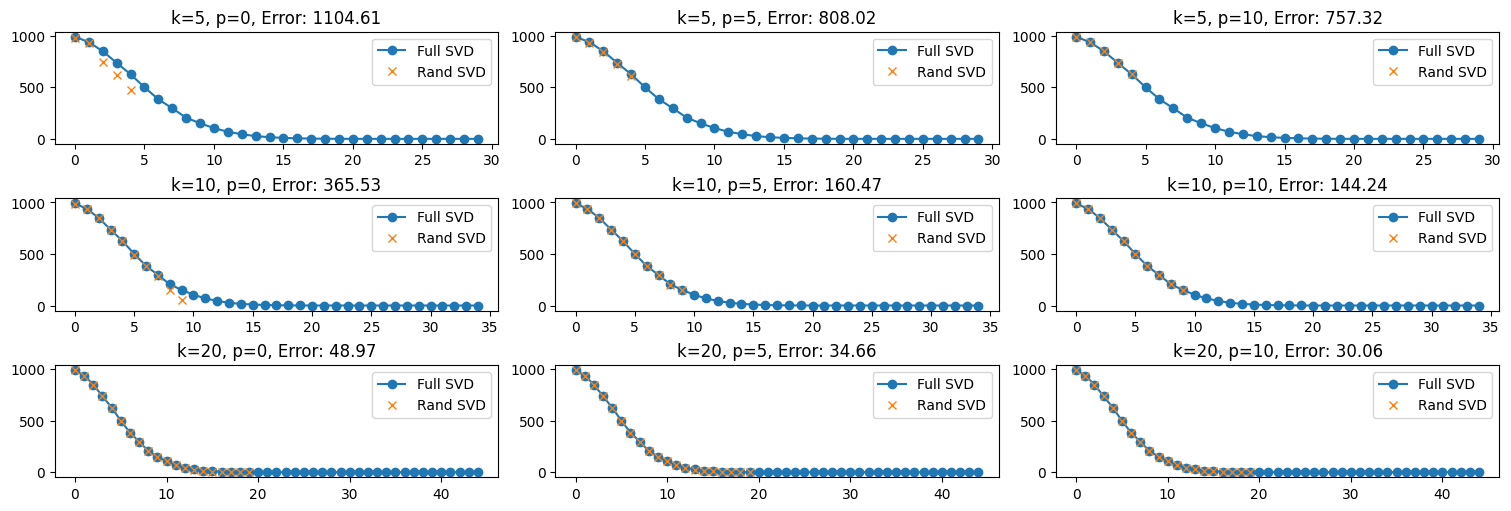

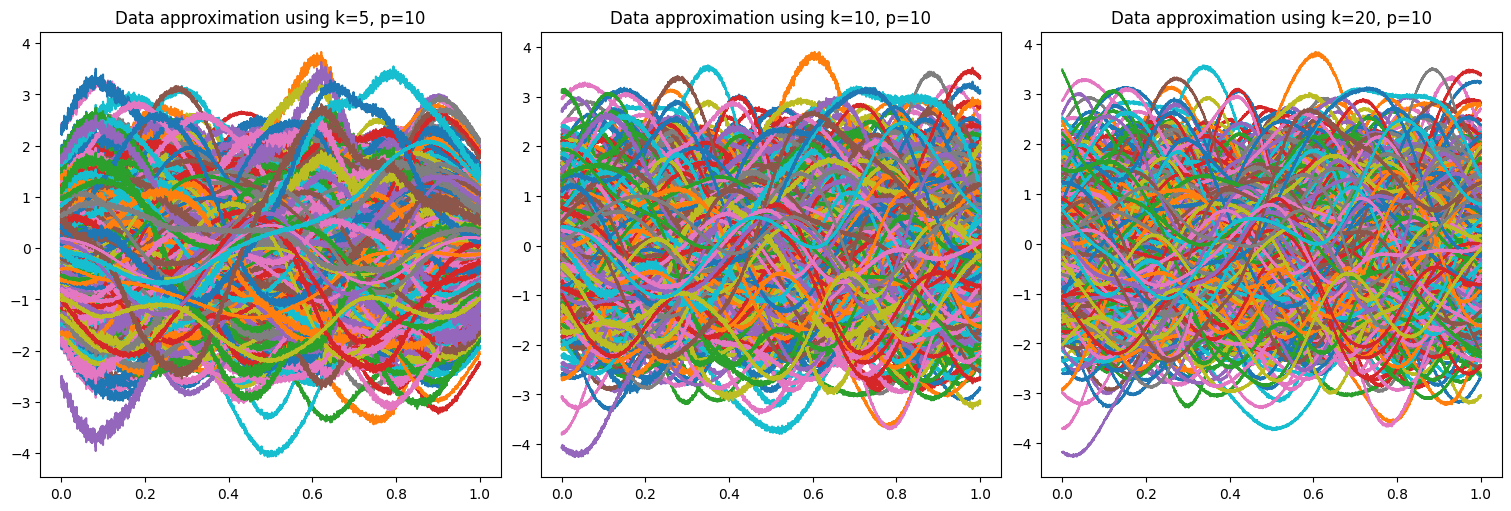

In [9]:
## Implementation of Randomized PCA on HW test data

# 1. Establish Parameters for validating Randomized PCA
k_values = [5, 10, 20] # k = rank of approximation
p_values = [0, 5, 10] # p = oversampling parameter
num_runs = 10 # All combinations will be run 10 times to determine mean and standard deviation

# 2. Center the data at 0 by removing the mean of the data row wise; each row is treated as a separate sensor
data_mean = np.mean(data, axis=1)[:, None]
data_centered = data - data_mean

# 3. Compute Full-rank Economy SVD once for reference
U_full, S_full, Vt_full = np.linalg.svd(data_centered, full_matrices=False)
data_approx_full = U_full @ np.diag(S_full) @ Vt_full

# 4. Compute Randomized SVD for different values of k and p
results = []
fig, ax = plt.subplots(len(k_values),len(p_values), figsize=(15,5), layout = 'constrained')
for i, k in enumerate(k_values):
    for j, p in enumerate(p_values):
        errors = []
        for run in range(num_runs):
            # Compute randomized SVD
            Uk_rand, Sk_rand, Vtk_rand = randomized_svd_truncated(data_centered, k, p)
                
            # Reconstruct the rank k approximate matrix A_k = Uk @ Sk @ Vtk
            data_approx_rand = Uk_rand @ np.diag(Sk_rand) @ Vtk_rand

            # Calculate the Frobenius norm error ‖X − X_approx_rand‖_F
            error = np.linalg.norm(data_approx_full - data_approx_rand, 'fro')
            errors.append(error)

        mean_error = np.mean(errors)
        std_error = np.std(errors)
        print(f'{k=} and {p=}: Mean Fro Error = {mean_error:.3f} and Std Dev Fro Error = {std_error:.3f}') # and Relative Fro Error = {mean_error/np.linalg.norm(data_approx_full, 'fro')}')
        ax[i,j].plot(S_full[:k+25], 'o-', label='Full SVD')
        ax[i,j].plot(Sk_rand[:k+25], 'x', label='Rand SVD')
        ax[i,j].set_title(f'k={k}, p={p}, Error: {mean_error:.2f}')
        ax[i,j].legend()

fig.savefig('Figure2.png')



# 5. Plot approximated data from k=5, 10, 20 and p=10
fig, ax = plt.subplots(1, len(k_values), figsize=(15,5), layout = 'constrained')
p = 10
for j, k in enumerate(k_values):
    # Compute randomized SVD
    Uk_rand, Sk_rand, Vtk_rand = randomized_svd_truncated(data_centered, k, p)

    # Reconstruct the rank k approximate matrix A_k = Uk @ Sk @ Vtk
    data_approx_rand = Uk_rand @ np.diag(Sk_rand) @ Vtk_rand

    # Plot 
    for i in range(N_samples):
        ax[j].plot(grid, data_approx_rand[:,i])  
        ax[j].set_title(f'Data approximation using k={k}, p=10')

plt.show()

                                          


## Part II: Video Background Subtraction

Reading video file
Each frame is 320 pixels wide and 240 pixels tall
Finished reading 794 frames


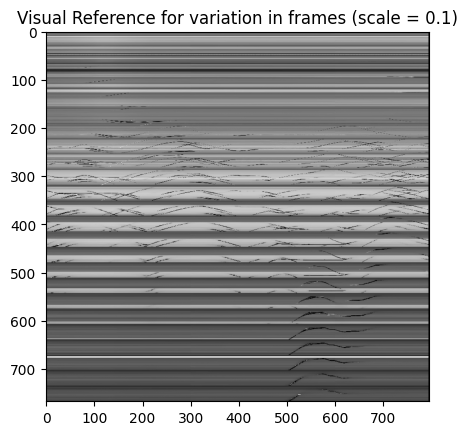

In [5]:
## This code reads the provided video and generates an array for data processing

cap = cv.VideoCapture('./Video.avi')

# 1. Check if video opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")  
print(f"Reading video file")

# 2. Identify the dimensions of the video including the number of frames
nf = int(cap.get(7)) # number of frames 
nx = int(cap.get(3)) # frame width
ny = int(cap.get(4)) # frame height
print(f'Each frame is {nx} pixels wide and {ny} pixels tall')
video = np.zeros((nx*ny, nf)) # This array will store the unpacked video, where each column is the entire frame at a single timepoint

# 2a. Store lower scale video for displaying changes in frames over time
ratio = 0.1 # rescaling factor
video_rescaled = np.zeros((int(ratio*nx)*int(ratio*ny), nf))

# 3. Unpack the video one frame at a time
frame_count = 0
while frame_count < nf:
  
  ret, frame = cap.read()
  if ret == True:
    frame_count += 1
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY) # Change the frame to grayscale for simpler calculations
    video[:, frame_count-1] = gray.flatten() # Flatten the frame and add to the video array for future processing
    
    # 3a. Store lower scale video for displaying changes in frames over time
    video_rescaled[:, frame_count-1] = cv.resize(  cv.cvtColor(frame, cv.COLOR_BGR2GRAY), (int(nx*ratio), int(ny*ratio)) ).flatten()

  else:
    break
  
# 4. Release the video capture object
cap.release()
cv.destroyAllWindows()
print(f'Finished reading {frame_count} frames')

# 5. Displaying the lower scale videos for identifying changes in frames over time
plt.imshow(video_rescaled, cmap = 'gray')
plt.title('Visual Reference for variation in frames (scale = 0.1)')
plt.savefig('Figure3.png')
plt.show()

(795,)


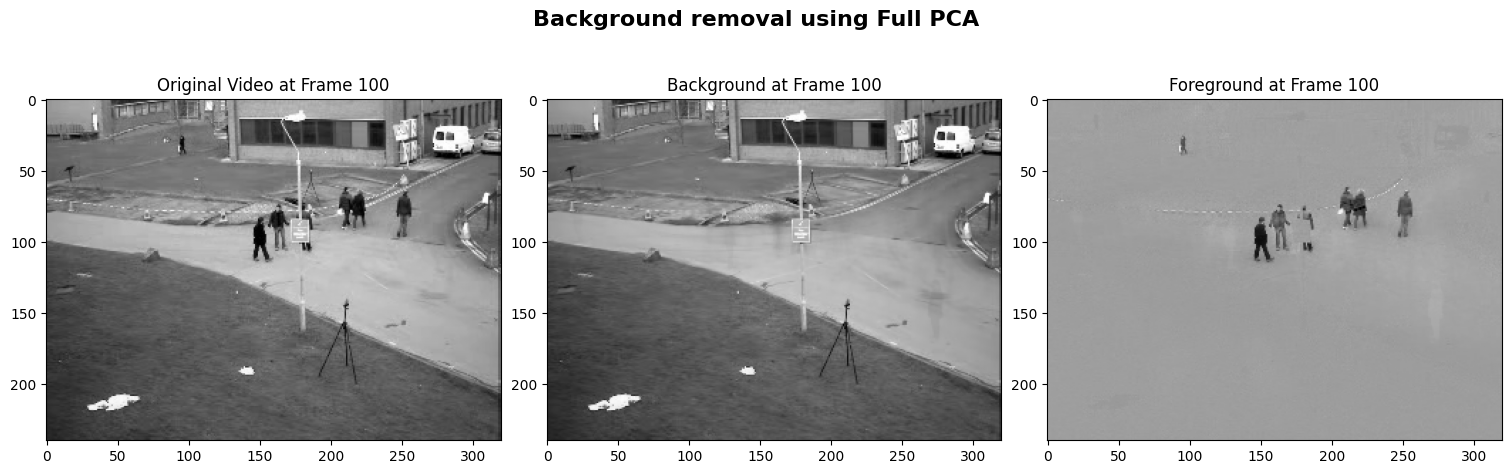

In [10]:
## Full PCA for Video 

# 1. Center the data at 0; this is important to ensure the largest values represent the highest variance
video_mean = np.mean(video, axis=1)[:, None]
video_centered = video - video_mean

# 2. Perform the Full-rank Economy SVD
u, s, vt = np.linalg.svd(video_centered, full_matrices=False)

print(s.shape)

# 3. Reconstruct the Background
# Use k=1 (the first singular value) to capture the static background
k = 1
# Background = U_k * S_k * Vt_k + original_mean
background_flat = u[:, :k] @ np.diag(s[:k]) @ vt[:k, :] + video_mean

# 4. Extract the Foreground
foreground_flat = video - background_flat

# 5. Generate and Save Figure
fig, ax = plt.subplots(1, 3, layout = 'constrained', figsize=(15,5))
fig.suptitle('Background removal using Full PCA', fontsize=16, fontweight='bold')

ax[0].imshow(video[:,100].reshape(ny, nx), cmap = 'gray')
ax[0].set_title('Original Video at Frame 100')

ax[1].imshow(background_flat[:,100].reshape(ny, nx), cmap = 'gray')
ax[1].set_title('Background at Frame 100')

ax[2].imshow(foreground_flat[:,100].reshape(ny, nx), cmap = 'gray')
ax[2].set_title('Foreground at Frame 100')

plt.show()
fig.savefig('Figure4.png')

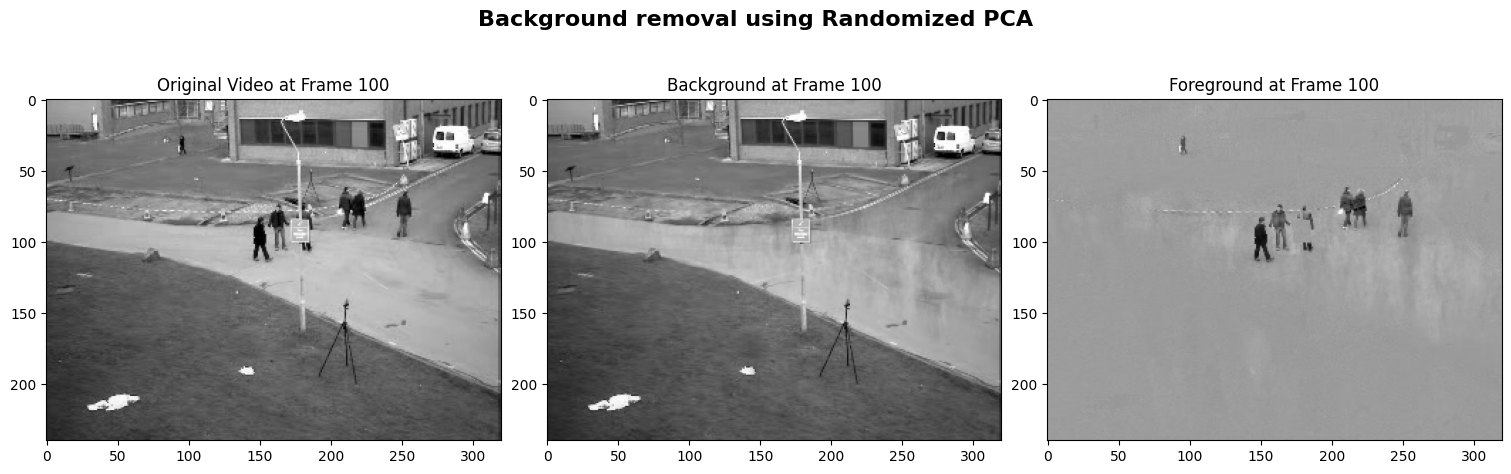

In [7]:
## Randomized PCA for Video 

# 1. Center the data at 0; this is important to ensure the largest values represent the highest variance
video_mean = np.mean(video, axis=1)[:, None]
video_centered = video - video_mean

# 2. Perform the Randomized SVD with rank = 1 (to capture only the static background) and oversampling parameter = 5
Uk_rand, Sk_rand, Vtk_rand = randomized_svd_truncated(video_centered, 1, 5)

# 3. Reconstruct the Background
background_flat = Uk_rand @ np.diag(Sk_rand) @ Vtk_rand + video_mean

# 4. Extract the Foreground
foreground_flat = video - background_flat

# 5. Generate and Save Figure
fig, ax = plt.subplots(1, 3, layout = 'constrained', figsize=(15,5))
fig.suptitle('Background removal using Randomized PCA', fontsize=16, fontweight='bold')

ax[0].imshow(video[:,100].reshape(ny, nx), cmap = 'gray')
ax[0].set_title('Original Video at Frame 100')

ax[1].imshow(background_flat[:,100].reshape(ny, nx), cmap = 'gray')
ax[1].set_title('Background at Frame 100')

ax[2].imshow(foreground_flat[:,100].reshape(ny, nx), cmap = 'gray')
ax[2].set_title('Foreground at Frame 100')

plt.show()
fig.savefig('Figure5.png')

In [8]:
## Additional Code to recreate video using only foreground

# Create VideoWriter object
fourcc = cv.VideoWriter_fourcc(*'XVID')
fps = 15
out = cv.VideoWriter('Foreground_Video.avi', fourcc, fps, (nx, ny), isColor=False)

# Reconstruct frames from the array and write to file
for i in range(nf):
    # Extract the column, reshape to original (height, width), and convert to uint8
    frame_reshaped = foreground_flat[:, i].reshape((ny, nx)).astype(np.uint8)
    
    # Write the frame to the output video
    out.write(frame_reshaped)

# Release the writer
out.release()
print("Video reconstruction complete: Saved as Foreground_Video.avi")


Video reconstruction complete: Saved as Foreground_Video.avi
